In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
from pathlib import Path
from datetime import datetime, timedelta

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func


In [4]:
database_path = Path("../Resources/hawaii.sqlite")

In [5]:
# Create engine using the `hawaii.sqlite` database file
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn = engine.connect()

In [6]:
# Declare a Base using `automap_base()`
Base = automap_base()

# Use the Base class to reflect the database tables
Base.prepare(engine, reflect=True)

C:\Users\tadak\AppData\Local\Temp\ipykernel_55776\3555078317.py:5: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [7]:
# Print all of the classes mapped to the Base
print(Base.classes.keys())

['measurement', 'station']


In [8]:
# Assign the measurement class to a variable called `Measurement` and
# assign the station class to a variable called `Station`
measurement = Base.classes.measurement
station = Base.classes.station

In [9]:
# Create a session
session = Session(engine)

# Exploratory Precipitation Analysis

In [10]:
# Find the most recent date in the data set.
most_recent_date = session.query(measurement.date).order_by(measurement.date.desc()).first()[0]
print(f"The most recent date in the dataset is: {most_recent_date}")

The most recent date in the dataset is: 2017-08-23


The date one year before the most recent date is: 2016-08-23


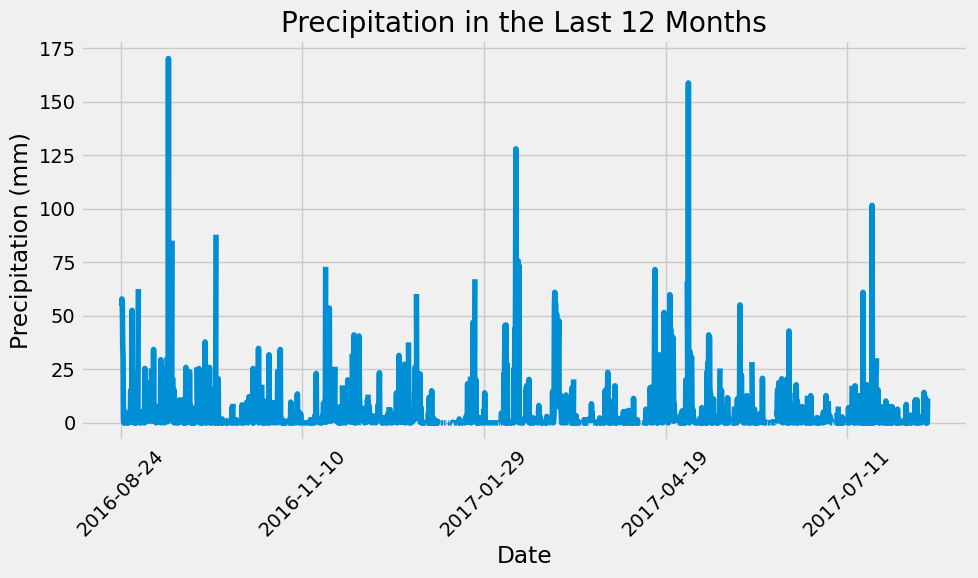

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results.
# Starting from the most recent data point in the database.
precipitation_data = session.query(measurement.date, measurement.prcp).\
    filter(measurement.date >= func.date(most_recent_date, '-1 year')).all()

# Calculate the date one year from the last date in data set.
most_recent_date_dt = datetime.strptime(most_recent_date, '%Y-%m-%d')
one_year_before_date = most_recent_date_dt - timedelta(days=365)
print(f"The date one year before the most recent date is: {one_year_before_date.strftime('%Y-%m-%d')}")


# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(measurement.date, measurement.prcp).\
    filter(measurement.date >= one_year_before_date).all()


# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(precipitation_data, columns=['date', 'prcp'])

# Sort the dataframe by date
precipitation_df = precipitation_df.sort_values('date')

# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot(x='date', y='prcp', figsize=(10, 6), title="Precipitation in the Last 12 Months", xlabel="Date", ylabel="Precipitation (mm)", legend=False)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [12]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_statistics = precipitation_df.describe()
print(summary_statistics)

              prcp
count  2015.000000
mean      4.485112
std      11.690532
min       0.000000
25%       0.000000
50%       0.500000
75%       3.300000
max     170.200000


# Exploratory Station Analysis

In [13]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(station.station)).scalar()
print(f"Total number of stations: {total_stations}")


Total number of stations: 9


In [14]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
most_active_stations = session.query(measurement.station, func.count(measurement.station)).\
    group_by(measurement.station).\
    order_by(func.count(measurement.station).desc()).all()
most_active_stations_df = pd.DataFrame(most_active_stations, columns=['Station', 'Count'])
print(most_active_stations_df)

       Station  Count
0  USC00519281   2772
1  USC00519397   2724
2  USC00513117   2709
3  USC00519523   2669
4  USC00516128   2612
5  USC00514830   2202
6  USC00511918   1979
7  USC00517948   1372
8  USC00518838    511


In [15]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station_id = most_active_stations_df.iloc[0]['Station']

temperature_stats = session.query(
    func.min(measurement.tobs),
    func.max(measurement.tobs),
    func.avg(measurement.tobs)
).filter(measurement.station == most_active_station_id).all()
print(f"Temperature statistics for the most active station ({most_active_station_id}):")
print(f"Lowest temperature: {temperature_stats[0][0]}")
print(f"Highest temperature: {temperature_stats[0][1]}")
print(f"Average temperature: {temperature_stats[0][2]}")


Temperature statistics for the most active station (USC00519281):
Lowest temperature: 12.2
Highest temperature: 29.4
Average temperature: 22.035822510822513


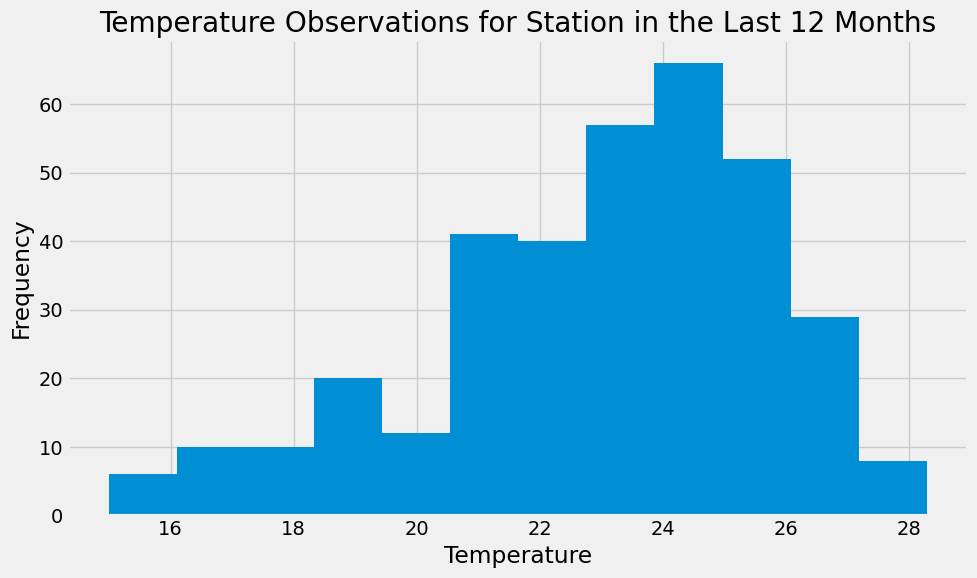

In [17]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperature_data = session.query(measurement.date, measurement.tobs).\
    filter(measurement.station == most_active_station_id).\
    filter(measurement.date >= one_year_before_date).all()


temperature_df = pd.DataFrame(temperature_data, columns=['date', 'tobs'])


temperature_df['tobs'].plot(kind='hist', bins=12, figsize=(10, 6), title=f"Temperature Observations for Station in the Last 12 Months")
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


# Close Session

In [21]:
# Close Session
session.close()
